# Alternative Tracing Methods

![AWTT](../../images/alternative_ways_to_trace_0.png)

So far in this module, we've taken a look at the traceable decorator, and how we can use it to set up tracing.

In this lesson, we're going to look at alternative ways in which we can set up tracing, and when you should think about using these different approaches.

## LangChain and LangGraph

If we are using LangChain or LangGraph, all we need to do to set up tracing is to set a few environment variables

![AWTT](../../images/alternative_ways_to_trace_1.png)

In [1]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

Don't worry too much about our graph implementation here, you can learn more about LangGraph through our LangGraph Academy course!

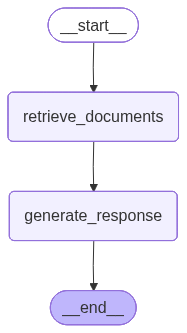

In [3]:
import nest_asyncio
import operator
from langchain.schema import Document
from langsmith import traceable
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

We're setting up a simple graph in LangGraph. If you want to learn more about LangGraph, I would highly recommend taking a look at our LangGraph Academy course.

You can also pass in metadata or other fields through an optional config

In [4]:
question = "How do I set up tracing if I'm using LangChain?"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"foo": "bar"}})

{'question': "How do I set up tracing if I'm using LangChain?",
 'messages': [HumanMessage(content="How do I set up tracing if I'm using LangChain?", additional_kwargs={}, response_metadata={}),
  AIMessage(content='To set up tracing with LangChain, you need to configure your environment by setting a few environment variables. After that, you can log a trace by following the instructions in the Trace With LangChain guide. For detailed steps, refer to the documentation provided by LangChain.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 1398, 'total_tokens': 1452, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CN5Wp9hRJ4gpKumwGYJ5y7g3GNXR5', 'service_tier': 'default', 

In [5]:
question = "Why is tracing useful in Langchain?"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"foo": "bar"}})

{'question': 'Why is tracing useful in Langchain?',
 'messages': [HumanMessage(content='Why is tracing useful in Langchain?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Tracing in LangChain is useful for observability and evaluation of large language model (LLM) workflows, allowing developers to monitor and analyze the performance of their applications. It helps in identifying bottlenecks, debugging issues, and optimizing the overall system by providing insights into the execution flow. Additionally, tracing facilitates better collaboration and understanding of complex interactions between different services.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 1394, 'total_tokens': 1466, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_nam

##### Let's take a look in LangSmith!

## Tracing Context Manager

In Python, you can use the trace context manager to log traces to LangSmith. This is useful in situations where:

You want to log traces for a specific block of code.
You want control over the inputs, outputs, and other attributes of the trace.
It is not feasible to use a decorator or wrapper.
Any or all of the above.
The context manager integrates seamlessly with the traceable decorator and wrap_openai wrapper, so you can use them together in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](../../images/alternative_ways_to_trace_2.png)

In [6]:
from langsmith import traceable, trace
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable
def retrieve_documents(question: str):
    documents = retriever.invoke(question)
    return documents

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    with trace(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "formatted_docs": formatted_docs},
        metadata={"foo": "bar"},
    ):
        messages = [
            {
                "role": "system",
                "content": RAG_SYSTEM_PROMPT
            },
            {
                "role": "user",
                "content": f"Context: {formatted_docs} \n\n Question: {question}"
            }
        ]
        response = call_openai(messages)
    return response
"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable
def call_openai(
  messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    return response

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [7]:
question = "How do I trace with tracing context?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To trace with the tracing context in Python, you can use the `tracing_context` context manager provided by LangSmith. Wrap your code that you want to trace within the `with ls.tracing_context(enabled=True):` block to enable tracing for that specific invocation. This allows you to selectively trace parts of your application without relying on environment variables.


In [8]:
from langsmith import trace

def to_uppercase(text: str) -> str:
    return text.upper()

def reverse_string(text: str) -> str:
    return text[::-1]

def string_workflow(text: str):
    with trace(
        name="String Workflow",
        run_type="chain",
        inputs={"text": text},
        metadata={"purpose": "demo of trace context manager with strings"}
    ) as t:
        upper = to_uppercase(text)
        reversed_text = reverse_string(upper)

        t.end(outputs={"uppercase": upper, "reversed": reversed_text})

    return upper, reversed_text

upper_val, reversed_val = string_workflow("LangSmith Demo")
print(f"Uppercase: {upper_val}, Reversed: {reversed_val}")


Uppercase: LANGSMITH DEMO, Reversed: OMED HTIMSGNAL


In [9]:
question = "How do I trace with tracing context?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To trace with the tracing context in Python, you can use the `tracing_context` context manager from the LangSmith SDK. Wrap your code that you want to trace within `with ls.tracing_context(enabled=True):` to enable tracing for that specific invocation. This allows you to selectively trace parts of your application without relying on environment variables.


## wrap_openai

The wrap_openai/wrapOpenAI methods in Python/TypeScript allow you to wrap your OpenAI client in order to automatically log traces -- no decorator or function wrapping required! The wrapper works seamlessly with the @traceable decorator or traceable function and you can use both in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](../../images/alternative_ways_to_trace_3.png)

In [11]:
from langsmith.wrappers import wrap_openai
import openai
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = openai.Client()

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable
def call_openai(
    messages: List[dict],
) -> str:
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

@traceable(run_type="chain")
def langsmith_rag_with_wrap_openai(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [12]:
question = "How do I trace with wrap_openai?"
ai_answer = langsmith_rag_with_wrap_openai(question)
print(ai_answer)

To trace with `wrap_openai`, you need to wrap your OpenAI client using the `wrap_openai` method from `langsmith.wrappers`. Ensure that the environment variable `LANGSMITH_TRACING` is set to 'true' and provide your LangSmith API key by setting the `LANGSMITH_API_KEY` environment variable. You can also specify the workspace with `LANGSMITH_WORKSPACE_ID` if your API key is linked to multiple workspaces.


In [13]:
from langsmith.wrappers import wrap_openai
import openai
from dotenv import load_dotenv
import os

load_dotenv()

client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

wrapped_client = wrap_openai(client)

def ask_openai(prompt: str):
    """Function that sends a prompt to the wrapped OpenAI client and returns response."""
    response = wrapped_client.chat.completions.create(
        model="gpt-4o-mini",  # You can change to gpt-4, gpt-4o, etc.
        messages=[{"role": "user", "content": prompt}],
        max_tokens=150,
        temperature=0.7
    )
    return response.choices[0].message.content

if __name__ == "__main__":
    answer1 = ask_openai("Explain the significance of the Mona Lisa painting in art history.")
    print("Response 1:\n", answer1, "\n")

    answer2 = ask_openai("Summarize the key features of Python programming language.")
    print("Response 2:\n", answer2)


Response 1:
 The **Mona Lisa**, painted by Leonardo da Vinci in the early 16th century, holds a pivotal place in art history for several reasons:

1. **Innovative Techniques**: Leonardo employed groundbreaking techniques such as sfumato, which creates a soft transition between colors and tones, enhancing the realism of the subject. This technique influenced countless artists and shifted the approach to portrait painting.

2. **Psychological Depth**: The Mona Lisa is renowned for its enigmatic expression and the sense of individuality it conveys. Da Vinci's ability to capture the subject's emotions and personality marked a shift towards greater psychological depth in portraiture, moving away from the more rigid and formal representations of earlier periods.

3. **Composition and Use of Space**: The composition 

Response 2:
 Python is a high-level, interpreted programming language known for its readability and versatility. Here are some key features:

1. **Readability**: Python’s syntax

In [16]:
messages = [
    {
        "role": "user",
        "content": "What color is the sky?"
    }
]

openai_client.chat.completions.create(
    model=MODEL_NAME,
    messages=messages,
    metadata={"foo": "bar"}
)

ChatCompletion(id='chatcmpl-CN5ijaCvXZbbWQbLLBQTjw5Oib8tp', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="The color of the sky can vary depending on the time of day, weather, and atmospheric conditions. During a clear day, the sky typically appears blue due to the scattering of sunlight by the Earth's atmosphere. Near sunrise and sunset, the sky can take on shades of orange, pink, and purple. On cloudy or overcast days, the sky may appear gray. Additionally, during events like storms, the sky can take on darker hues.", refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1759619569, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_51db84afab', usage=CompletionUsage(completion_tokens=88, prompt_tokens=13, total_tokens=101, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reason

The wrapped OpenAI client accepts all the same langsmith_extra parameters as @traceable decorated functions

## [Advanced] RunTree

Another, more explicit way to log traces to LangSmith is via the RunTree API. This API allows you more control over your tracing - you can manually create runs and children runs to assemble your trace. You still need to set your `LANGSMITH_API_KEY`, but `LANGSMITH_TRACING` is not necessary for this method.

![AWTT](../../images/alternative_ways_to_trace_4.png)

In [17]:
from dotenv import load_dotenv
# I have my env variables defined in a .env file
load_dotenv(dotenv_path="../../.env", override=True)

True

Let's go ahead and set `LANGSMITH_TRACING` to false, as we are using RunTree to manually create runs in this case.

In [18]:
import os
os.environ["LANGSMITH_TRACING"] = "false"

from langsmith import utils
utils.tracing_is_enabled() # This should return false

False

We have rewritten our RAG application, except this time we pass a RunTree argument through our function calls, and create child runs at each layer. This gives our RunTree the same hierarchy that we were automatically able to establish with @traceable

In [19]:
from langsmith import RunTree
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

def retrieve_documents(parent_run: RunTree, question: str):
    # Create a child run
    child_run = parent_run.create_child(
        name="Retrieve Documents",
        run_type="retriever",
        inputs={"question": question},
    )
    documents = retriever.invoke(question)
    # Post the output of our child run
    child_run.end(outputs={"documents": documents})
    child_run.post()
    return documents

def generate_response(parent_run: RunTree, question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    # Create a child run
    child_run = parent_run.create_child(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "documents": documents},
    )
    messages = [
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    openai_response = call_openai(child_run, messages)
    # Post the output of our child run
    child_run.end(outputs={"openai_response": openai_response})
    child_run.post()
    return openai_response

def call_openai(
    parent_run: RunTree, messages: List[dict], model: str = "gpt-4o-mini", temperature: float = 0.0
) -> str:
    # Create a child run
    child_run = parent_run.create_child(
        name="OpenAI Call",
        run_type="llm",
        inputs={"messages": messages},
    )
    openai_response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    # Post the output of our child run
    child_run.end(outputs={"openai_response": openai_response})
    child_run.post()
    return openai_response

def langsmith_rag(question: str):
    # Create a root RunTree
    root_run_tree = RunTree(
        name="Chat Pipeline",
        run_type="chain",
        inputs={"question": question}
    )

    # Pass our RunTree into the nested function calls
    documents = retrieve_documents(root_run_tree, question)
    response = generate_response(root_run_tree, question, documents)
    output = response.choices[0].message.content

    # Post our final output
    root_run_tree.end(outputs={"generation": output})
    root_run_tree.post()
    return output
    


In [20]:
from langsmith import RunTree

def concatenate_strings(parent_run: RunTree, strings):
    child_run = parent_run.create_child(
        name="Concatenate Strings",
        run_type="tool",
        inputs={"strings": strings}
    )
    result = " ".join(strings)
    child_run.end(outputs={"concatenated": result})
    child_run.post()
    return result

def count_words(parent_run: RunTree, text):
    child_run = parent_run.create_child(
        name="Count Words",
        run_type="tool",
        inputs={"text": text}
    )
    count = len(text.split())
    child_run.end(outputs={"word_count": count})
    child_run.post()
    return count

def text_pipeline(strings):
    root_run = RunTree(name="Text Pipeline Demo", run_type="chain", inputs={"strings": strings})
    concatenated = concatenate_strings(root_run, strings)
    word_count = count_words(root_run, concatenated)
    root_run.end(outputs={"concatenated": concatenated, "word_count": word_count})
    root_run.post()
    return concatenated, word_count, root_run

def print_run_tree(run: RunTree, indent=0):
    spacer = " " * indent
    print(f"{spacer}{run.name}")
    if run.inputs:
        print(f"{spacer}  inputs: {run.inputs}")
    if run.outputs:
        print(f"{spacer}  outputs: {run.outputs}")
    for child in getattr(run, "children", []):
        print_run_tree(child, indent + 4)

strings = ["LangSmith", "makes", "tracing", "easy"]
concatenated, word_count, run_tree = text_pipeline(strings)

print(f"Concatenated: {concatenated}, Word Count: {word_count}\n")
print("RunTree trace:")
print_run_tree(run_tree)


Concatenated: LangSmith makes tracing easy, Word Count: 4

RunTree trace:
Text Pipeline Demo
  inputs: {'strings': ['LangSmith', 'makes', 'tracing', 'easy']}
  outputs: {'concatenated': 'LangSmith makes tracing easy', 'word_count': 4}


In [21]:
question = "How can I trace with RunTree?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To trace with RunTree, you can use the `RunTree.fromHeaders` method to create a run tree from the request headers. Then, utilize the `withRunTree` helper to ensure the run tree is propagated within traceable invocations. This allows you to maintain the context of the trace throughout your application's operations.
